In [ ]:
'''
1. Sentiment Classification using Transformer Encoder 
Dataset: IMDB reviews / Yelp / Amazon reviews 
Goal: Build a basic Transformer encoder for binary sentiment classification. 
Key tasks: 
 Tokenize & pad sequences 
 Implement Transformer encoder layer (Multi-head Attention + FFN) 
 Positional Encoding 
 Feed into a final Dense layer for binary classification 
'''

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [2]:
# Positional Encoding
# Source: Adapted from https://www.tensorflow.org/text/tutorials/transformer#positional_encoding
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [3]:
# Multi-Head Attention Layer
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8, **kwargs):
        super(MultiHeadSelfAttention, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)
    def attention(self, query, key, value, mask=None):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        if mask is not None:
            # The mask is added to the scaled tensor.
            # A large negative number (e.g. -1e9) is added to the padding tokens.
            # This will make their softmax scores nearly zero.
            scaled_score += (mask * -1e9)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs, training=None, mask=None):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)

        attention, weights = self.attention(query, key, value, mask)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

In [4]:
# Transformer Encoder Layer
class TransformerEncoderLayer(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerEncoderLayer, self).__init__(**kwargs)
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=None, mask=None):
        attn_output = self.att(inputs, training=training, mask=mask) # Pass mask here
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [5]:
# Token and Position Embedding Layer
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, **kwargs):
        super(TokenAndPositionEmbedding, self).__init__(**kwargs)
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = positional_encoding(maxlen, embed_dim) # Using the function directly
        self.embed_dim = embed_dim
        self.maxlen = maxlen
        self.vocab_size = vocab_size

    def call(self, x):
        # Ensure x is not longer than maxlen for position embedding
        seq_len = tf.shape(x)[-1]
        # Take the slice of pos_emb that corresponds to the actual sequence length
        # This handles cases where input sequences might be shorter than maxlen after padding
        # and ensures broadcasting works correctly.
        # However, for a fixed maxlen model, inputs are usually padded to maxlen.
        # If inputs are guaranteed to be padded to maxlen, this slicing might not be strictly necessary
        # but provides robustness.
        positions = self.pos_emb[:, :seq_len, :]
        x = self.token_emb(x)
        return x + positions

    def get_config(self):
        config = super().get_config()
        config.update({
            "maxlen": self.maxlen,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config

In [6]:
# Parameters for the dataset and model
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
embed_dim = 128  # Embedding size for each token
num_heads = 4  # Number of attention heads
ff_dim = 128  # Hidden layer size in feed forward network inside transformer
batch_size = 32

print("Loading IMDB dataset...")
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(
    num_words=vocab_size
)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")

print("Pad sequences (samples x time)...")
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)
print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)

# Create tf.data datasets for better performance
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

Loading IMDB dataset...
25000 Training sequences
25000 Validation sequences
Pad sequences (samples x time)...
x_train shape: (25000, 200)
x_val shape: (25000, 200)


In [7]:
# Define input padding mask function
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [8]:
# Build the model
inputs = layers.Input(shape=(maxlen,))
# Create mask before it's passed to the embedding layer,
# as embedding layer doesn't accept a mask argument in the functional API setup directly.
# The mask will be passed to the TransformerEncoderLayer.
padding_mask = layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='padding_mask')(inputs)

embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)

In [9]:
# We'll use one Transformer Encoder layer as requested for a "basic" encoder
transformer_block = TransformerEncoderLayer(embed_dim, num_heads, ff_dim, name="transformer_layer")
x = transformer_block(x, mask=padding_mask) # Pass the mask here

In [10]:
# Global Average Pooling to get a fixed-size vector for classification
x = layers.GlobalAveragePooling1D()(x)
# Dropout for regularization
x = layers.Dropout(0.1)(x)
# Final Dense layer for binary classification
outputs = layers.Dense(1, activation="sigmoid")(x) # Sigmoid for binary classification

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 200)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_and_position_embedding  │ (None, 200, 128)          │       2,560,000 │ input_layer[0][0]          │
│ (TokenAndPositionEmbedding)   │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ padding_mask (Lambda)         │ (None, 1, 1, None)        │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ transformer_layer             │ (None, 200, 128)          │          99,584 │ token_and_position_embedd… │
│ (TransformerEncoderLayer)     │                           │                 │ padding_mask[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling1d      │ (None, 128)               │               0 │ transformer_layer[0][0]    │
│ (GlobalAveragePooling1D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 128)               │               0 │ global_average_pooling1d[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 1)                 │             129 │ dropout_2[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,659,713 (10.15 MB)

 Trainable params: 2,659,713 (10.15 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [12]:
epochs = 10

print("Training model...")
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
)

Training model...
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 123s 152ms/step - accuracy: 0.5185 - loss: 0.7080 - val_accuracy: 0.7365 - val_loss: 0.6097
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 120s 153ms/step - accuracy: 0.7633 - loss: 0.5017 - val_accuracy: 0.8571 - val_loss: 0.3254
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 121s 155ms/step - accuracy: 0.8727 - loss: 0.2989 - val_accuracy: 0.8704 - val_loss: 0.3018
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 120s 153ms/step - accuracy: 0.9091 - loss: 0.2342 - val_accuracy: 0.8557 - val_loss: 0.3503
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 121s 154ms/step - accuracy: 0.9233 - loss: 0.1975 - val_accuracy: 0.8661 - val_loss: 0.3354
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 131s 168ms/step - accuracy: 0.9414 - loss: 0.1577 - val_accuracy: 0.8278 - val_loss: 0.5095
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 134s 172ms/step - accuracy: 0.9571 - loss: 0.1208 - val_accuracy: 0.8624 - val_loss: 0.4208
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 140s 179ms/step - 

Evaluating model...
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.8398 - loss: 0.7626
Validation Loss: 0.7739
Validation Accuracy: 0.8390


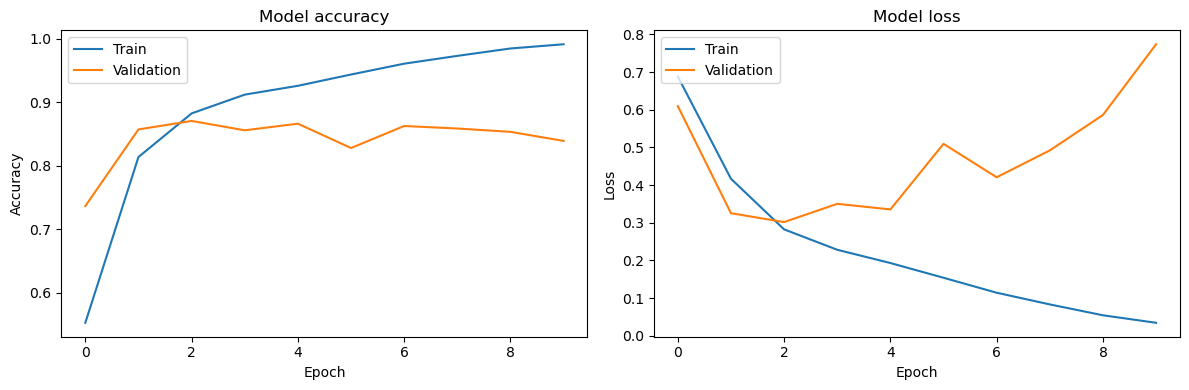

In [13]:
print("Evaluating model...")
loss, accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Plot training & validation accuracy values
if history is not None:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()